In [1]:
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib
from astropy.cosmology import Planck15 as cosmo, z_at_value
from astropy import coordinates as coord
import healpy as hp
from scipy import stats 
import sys,os

In [2]:
# define particle datatype
vect = np.dtype([('x', np.float32),('y', np.float32),('z', np.float32)])
part = np.dtype([('pos', vect),('vel', vect),('ID', np.ulonglong), ('z', np.float32), ('r', np.float32),('RA', np.float32),('Dec', np.float32)])

In [3]:
fname = '/cosma7/data/dp004/dc-boot5/Lightcone/DM_shells_indexed/L750.hdf5'

In [4]:
p = np.empty(0, dtype=part)
with h5py.File(fname,'r') as f:
    for k in f.keys():
        print (k)
        p = np.append(p,f[k])

LC_Particles_snap_110
LC_Particles_snap_111
LC_Particles_snap_113
LC_Particles_snap_114
LC_Particles_snap_115
LC_Particles_snap_116
LC_Particles_snap_117
LC_Particles_snap_119
LC_Particles_snap_120
LC_Particles_snap_121
LC_Particles_snap_123
LC_Particles_snap_124
LC_Particles_snap_126
LC_Particles_snap_127


In [5]:
depth = 10
radius = 375
p_slice = p[(abs(p['pos']['z'])< depth) & (p['r'] <= radius)]
print('Done slicing')

Done slicing


In [6]:
# view max and min values for particle coordinates
x = p_slice['pos']['x']
y = p_slice['pos']['y']
z = p_slice['pos']['z']
zz = p_slice['z']
r = p_slice['r']
np.array([[np.amin(x), np.amax(x)], [np.amin(y), np.amax(y)], [np.amin(z), np.amax(z)]])

array([[-374.86914  ,  374.9306   ],
       [-374.82098  ,  374.85706  ],
       [  -9.9999695,    9.9999695]], dtype=float32)

In [7]:
x_max = np.amax(abs(x))
y_max = np.amax(abs(y))
r_min = np.amin(r)
r_max = np.amax(r)
z_max = np.amax(np.abs(z))
R_max = (r_max//200 +1) * 200
print(r_min, r_max, z_max, x_max, y_max, R_max)

1.5649495 374.99985 9.9999695 374.9306 374.85706 400.0


In [8]:
# set density deposition mode
mode = 'NGP' #'CIC' #'NGP' # alternative is 'CIC'
size = 2000 # size of image array/2
X = x * size/x_max + size-1 # rescale x axis
Y = y * size/y_max + size-1 # rescale y axis

# Calculate cell in which each galaxy is located on 2D grid
i = np.floor(X)
j = np.floor(Y)
i = i.astype(int) # x index of cell that contains particle
j = j.astype(int) # y index of cell that contains particle

# define image mesh
img = np.full((2*size,2*size),0.0001)

# calcuate total density in each image grid cell by summing over all particles
for k,p_ in enumerate(p_slice):
    if mode=='CIC' and i[k]<2*size-1 and j[k]<2*size-1:
        d_x = X[k] - i[k]  # x offset of particle in cell
        d_y = Y[k] - j[k]  # y offset of particle in cell
        t_x = 1 - d_x
        t_y = 1 - d_y

        img[i[k],j[k]]    += t_x * t_y
        img[i[k]+1,j[k]]  += d_x * t_y
        img[i[k],j[k]+1]  += t_x * d_y
        img[i[k]+1,j[k]+1]+= d_x * d_y
    else:       # if NGP mode or on grid boundary
        img[i[k],j[k]]+= 1
        
L_max = np.amax(img)
L_min = np.amin(img)
print ('L_max = ', L_max, 'L_min = ', L_min)

L_max =  258.0001 L_min =  0.0001


In [9]:
# set up colour map
cdict = {'red':   [[0.0, 0.0, 0.0],
                   [0.1, 0.0, 0.0],
                   [1.0, 1.0, 1.0]],
         'green': [[0.0, 0.0, 0.0],
                   [0.1, 0.0, 0.0],
                   [1.0, 1.0, 1.0]],
         'blue':  [[0.0, 0.0, 0.0],
                   [0.1, 1.0, 1.0],
                   [1.0, 0.2, 0.2]]}

cmap_name = 'blue1'
newcmp1 = LinearSegmentedColormap(cmap_name, segmentdata=cdict, N=256)

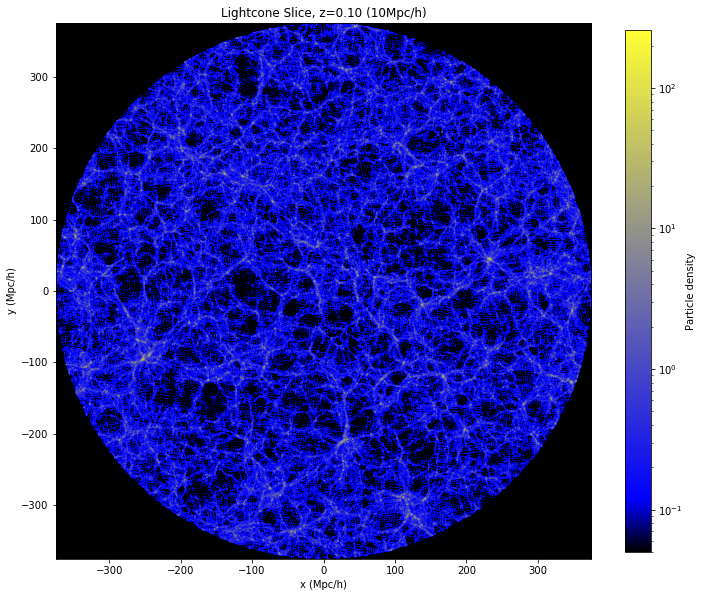

In [10]:
Dpi = 600
z = 0.10
Cmap = newcmp1
Cmap.set_under('k')
#Interp = 'None'
Interp = 'kaiser'
#Norm = cm.colors.Normalize(vmin=0.01, vmax=L_max)
#Norm = cm.colors.PowerNorm(gamma=0.1)
Norm = cm.colors.LogNorm(vmin=0.05, vmax=L_max)
ext = (-r_max, r_max, -r_max, r_max)
fig = plt.subplots(figsize = (12,12))
plt.imshow(img,  cmap = Cmap, norm = Norm, interpolation = Interp, extent = ext)
cbar = plt.colorbar(shrink = 0.8)
cbar.set_label('Particle density')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.title('Lightcone Slice, z={0:0.2f} (10Mpc/h)'.format(z))
#plt.savefig('DM_Particle_Stepped_Lightcone_Slice_z={5:n}_mode-{0:s}_interp-{1:s}_res-{2:0d}_dpi-{3:0d}_cmap-{4:s}.png'
            #.format(mode,Interp, size*2, Dpi, Cmap.name,z),transparent = False, dpi = Dpi, bbox_inches = 'tight')
plt.show()

In [7]:
#Nparts = (np.ulonglong)(np.amax(p['ID'] + 1))
Nparts = 2**27 
print('Number of particles',Nparts)

Number of particles 134217728


In [8]:
po = np.empty(Nparts+1, dtype=part)

In [9]:
po.size

134217729

In [10]:
po[p['ID']] = p
print ('Done re-ordering particles')

Done re-ordering particles


In [12]:
po[po['ID']>0][:10]

array([((369.88898,  373.66364, -159.08545), ( 375.94427,  482.8724  ,  599.9303 ), 138, 0.19284469, 549.3183 ,  45.290855, -16.834322),
       ((369.1977 ,  374.17114, -160.55943), (1135.816  ,  135.80338 , -381.3468 ), 142, 0.19295824, 549.62744,  45.383327, -16.985167),
       ((369.1872 ,  373.34955, -155.28279), (-215.07494, -790.5124  , 1147.3741 ), 143, 0.19219224, 547.5416 ,  45.32117 , -16.475178),
       ((371.1411 ,  373.89374, -153.49648), (-197.86551, -388.9356  ,  488.40234), 144, 0.19262822, 548.7289 ,  45.21168 , -16.24415 ),
       ((371.83032,  374.375  , -153.41325), (-162.28012,    8.035684,  689.88464), 145, 0.19291136, 549.4998 ,  45.195385, -16.211693),
       ((370.95837,  374.23633, -154.92424), (-505.8318 , -259.97998 ,  159.35056), 150, 0.1928159 , 549.2399 ,  45.252026, -16.3838  ),
       ((373.06335, -373.8088 , -152.33455), (-207.45877, -301.3288  , -323.4588 ), 151, 0.19296652, 549.65   , -45.057186, -16.090076),
       ((373.17932, -373.27774, -151.8714

In [25]:
nfiles = 16
subfiles=2
z = 0.10
p1 = np.empty(0, dtype=part)
#fpath = '/cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/redshift{0:0.2f}/'.format(z)
fpath = '/cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Lightcone7/'
#fpath = '/cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/redshift{0:0.2f}/Lightcone7/'.format(z)
for fileno in range(nfiles):
    for sub in range(subfiles):
        fname = fpath + 'Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.{0:d}.{1:d}'.format(fileno, sub)
        # Check that file actually exists 
        if os.path.exists(fname):
            with h5py.File(fname,'r') as f:
                pts =np.empty(f['LC_Particles'].shape, dtype=part)
                f['LC_Particles'].read_direct(pts)  
                p1 = np.append(p1,pts)
            print('File {0:d}.{1:d} read'.format(fileno, sub))
        else:
             print('Lightcone file {0:d}.{1:d} does not exist'.format(fileno, sub))

Lightcone file 0.0 does not exist
Lightcone file 0.1 does not exist
File 1.0 read
Lightcone file 1.1 does not exist
File 2.0 read
Lightcone file 2.1 does not exist
File 3.0 read
Lightcone file 3.1 does not exist
File 4.0 read
File 4.1 read
File 5.0 read
File 5.1 read
File 6.0 read
File 6.1 read
File 7.0 read
File 7.1 read
File 8.0 read
File 8.1 read
File 9.0 read
File 9.1 read
File 10.0 read
File 10.1 read
File 11.0 read
File 11.1 read
File 12.0 read
Lightcone file 12.1 does not exist
File 13.0 read
Lightcone file 13.1 does not exist
File 14.0 read
Lightcone file 14.1 does not exist
Lightcone file 15.0 does not exist
Lightcone file 15.1 does not exist


In [26]:
pi1 = np.empty(Nparts+1, dtype=part)
pi1[p1['ID']] = p1
print ('Done re-ordering particles')

Done re-ordering particles


In [37]:
nfiles = 16
subfiles=2
z = 0.10
p2 = np.empty(0, dtype=part)
fpath = '/cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/redshift{0:0.2f}/Lightcone7/'.format(z)
#fpath = '/cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/redshift{0:0.2f}_alt_snaps/'.format(z)
for fileno in range(nfiles):
    for sub in range(subfiles):
        fname = fpath + 'Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.{0:d}.{1:d}'.format(fileno, sub)
        # Check that file actually exists for this snapshot
        if os.path.exists(fname):
            with h5py.File(fname,'r') as f:
                pts =np.empty(f['LC_Particles'].shape, dtype=part)
                f['LC_Particles'].read_direct(pts)  
                p2 = np.append(p2,pts)
            print('File {0:d}.{1:d} read'.format(fileno, sub))
        else:
            print('Lightcone file {0:d}.{1:d} does not exist'.format(fileno, sub))

Lightcone file 0.0 does not exist
Lightcone file 0.1 does not exist
File 1.0 read
Lightcone file 1.1 does not exist
File 2.0 read
Lightcone file 2.1 does not exist
File 3.0 read
Lightcone file 3.1 does not exist
File 4.0 read
File 4.1 read
File 5.0 read
File 5.1 read
File 6.0 read
File 6.1 read
File 7.0 read
File 7.1 read
File 8.0 read
File 8.1 read
File 9.0 read
File 9.1 read
File 10.0 read
File 10.1 read
File 11.0 read
File 11.1 read
File 12.0 read
Lightcone file 12.1 does not exist
File 13.0 read
Lightcone file 13.1 does not exist
File 14.0 read
Lightcone file 14.1 does not exist
Lightcone file 15.0 does not exist
Lightcone file 15.1 does not exist


In [38]:
pi2 = np.empty(Nparts+1, dtype=part)
pi2[p2['ID']] = p2
print ('Done re-ordering particles')

Done re-ordering particles


In [27]:
dx = po['pos']['x'] - pi1['pos']['x']
dy = po['pos']['y'] - pi1['pos']['y']
dz = po['pos']['z'] - pi1['pos']['z']
r = po['r']
f = (po['ID']>0) &  (pi1['ID']>0)
dx = dx[f]
dy = dy[f]
dz = dz[f]
dp = np.sqrt(dx*dx + dy*dy + dz*dz)
R = r[f]
F = R<280
R1 = R[F]
dp1 = dp[F]

In [51]:
dx = po['pos']['x'] - pi2['pos']['x']
dy = po['pos']['y'] - pi2['pos']['y']
dz = po['pos']['z'] - pi2['pos']['z']
r = po['r']
f = (po['ID']>0) &  (pi2['ID']>0)
dx = dx[f]
dy = dy[f]
dz = dz[f]
dp = np.sqrt(dx*dx + dy*dy + dz*dz)
R = r[f]
po0 = po[f]
pi0 = pi2[f]
F = (R<200) 
R2 = R[F]
dp2 = dp[F]
po1 = po0[F]
pi3 = pi0[F]

In [50]:
f.sum(), f.size

(32494734, 134217729)

In [39]:
v1 = np.sqrt(pi3['vel']['x']**2 + pi3['vel']['y']**2 + pi3['vel']['z']**2)

In [40]:
v = np.sqrt(po1['vel']['x']**2 + po1['vel']['y']**2 + po1['vel']['z']**2)

In [132]:
# compare velocities of the two lightcones
# sliced cone has high end velocities where Delta x > 5 Mpc
v,v1

(array([2791.8464, 2447.2625, 2389.9656, 2832.3547, 2419.0728, 2785.4854,
        3087.1648, 3216.974 , 3171.3362, 3101.7368, 2793.9573, 3126.0994,
        3202.0723, 2963.7703, 2868.3823, 2565.2654, 2987.616 , 3230.8777,
        2974.334 , 2589.4043, 2784.7214, 2600.7236, 2476.7034, 2971.8801,
        3157.467 , 3096.052 , 2810.4976, 2694.4524, 2701.3367, 2647.9214,
        2666.5984, 2798.6438, 2707.964 , 3057.4207, 3167.9412, 2768.8074,
        2966.0725, 2558.482 , 2513.8604, 2885.573 , 2921.6143, 2785.5825,
        2517.016 , 3108.593 , 2486.0496, 1930.4225], dtype=float32),
 array([1260.7773 , 1344.5854 , 1278.2299 , 1376.6472 , 1365.3027 ,
        1437.8347 , 1443.0422 , 1258.0367 , 1368.7688 , 1349.7726 ,
        1284.851  , 1276.9467 , 1310.1523 , 1298.5409 , 1259.9918 ,
        1407.6207 , 1300.5587 , 1384.6063 , 1330.0408 , 1411.6508 ,
        1219.1927 , 1362.4518 , 1252.9084 , 1230.3137 , 1141.602  ,
        1299.2465 ,  708.3141 , 1175.0016 , 1133.3593 , 1155.3058 ,
     

In [67]:
# Load ordered snapshots
snap_path = '/cosma6/data/dp004/dc-boot5/Ordered_Snapshots/Npart_512_Box_750-Fiducial/'

In [77]:
snap = 124
fnameA = snap_path + 'ordered_snapshot.snap_{0:03d}.hdf5'.format(snap)

In [78]:
with h5py.File(fnameA, 'r') as fA:
    h = fA['Header']
    NumParts = h.attrs['NumPart_Total'][1]
    zA = h.attrs['Redshift']
    pA =np.empty(fA['PartType1'].shape, dtype=part)
    fA['PartType1'].read_direct(pA)  
print('Done A, z = {0:0.3f} number of particles = {1:0d}'.format(zA,NumParts))

Done A, z = 0.015 number of particles = 134217728


In [79]:
snap = 126
fnameB = snap_path + 'ordered_snapshot.snap_{0:03d}.hdf5'.format(snap)

In [80]:
with h5py.File(fnameB, 'r') as fB:
    h = fB['Header']
    zB = h.attrs['Redshift']
    pB =np.empty(fB['PartType1'].shape, dtype=part)
    fB['PartType1'].read_direct(pB)  
print('Done B, z = {0:0.3f} '.format(zB))

Done B, z = 0.000 


In [137]:
pA[34976541],pB[34976541]

(((192.58765, 303.47372, 402.7259), (-1935.9542, -440.86182, -1066.9276), 34976541, 0., 0., 0., 0.),
 ((192.3116, 303.41714, 402.57324), (-1726.1759, -335.5006, -957.5459), 34976541, 0., 0., 0., 0.))

In [138]:
vA = np.sqrt(pA['vel']['x']**2 + pA['vel']['y']**2 + pA['vel']['z']**2)
vB = np.sqrt(pB['vel']['x']**2 + pB['vel']['y']**2 + pB['vel']['z']**2)

In [139]:
vA[70924054],vB[70924054]

(2881.7908, 2123.0134)

In [76]:
cosmo.comoving_distance(0.01286168)

<Quantity 56.75098067 Mpc>

In [54]:
dx = pi1['pos']['x'] - pi2['pos']['x']
dy = pi1['pos']['y'] - pi2['pos']['y']
dz = pi1['pos']['z'] - pi2['pos']['z']
r = pi1['r']
f = (pi1['ID']>0) &  (pi2['ID']>0)
dx = dx[f]
dy = dy[f]
dz = dz[f]
dp = np.sqrt(dx*dx + dy*dy + dz*dz)
R = r[f]
F = R<280
R3 = R[F]
dp3 = dp[F]

In [101]:
dp1[:10]

array([0.19308689, 0.2505599 , 0.21544185, 0.26385388, 0.19384591,
       0.25082937, 0.47824323, 0.76334196, 0.49368444, 0.275687  ],
      dtype=float32)

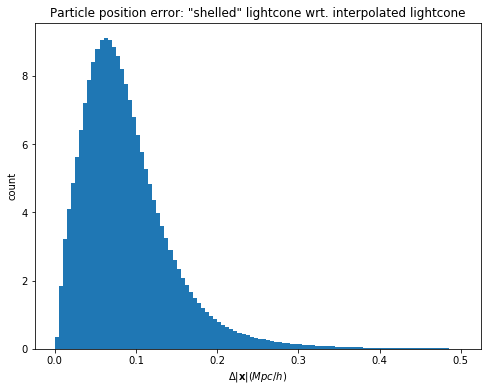

In [18]:
fig = plt.subplots(figsize = (8,6))
plt.hist(dp1 , density=True, log=False, bins=100, histtype='stepfilled', range = (0,0.5), label='All snapshots')
#plt.hist(dp2 , density=True, log=False, bins=100, histtype='stepfilled', range = (0,4), label='Every other snapshot')
#plt.hist(dp3 , density=True, log=False, bins=100, histtype = 'step', range = (0.01,6))
plt.xlabel('$\Delta \| \mathbf{x} \|(Mpc/h)$')
plt.ylabel('count')
plt.title('Particle position error: "shelled" lightcone wrt. interpolated lightcone')
#plt.legend()
plt.savefig('error_histogram_fix_H0.png')
plt.show()

In [28]:
DC_z = [ 2.81391494e+02,  2.33621996e+02,
        1.86189359e+02,  1.39102503e+02,  9.23699644e+01,  4.59998830e+01]

In [56]:
bin_means1, bin_edges1, binnumber1 = stats.binned_statistic(R1, dp1, statistic='mean', bins=1000)
bin_means2, bin_edges2, binnumber2 = stats.binned_statistic(R2, dp2, statistic='mean', bins=1000)
bin_means3, bin_edges3, binnumber3 = stats.binned_statistic(R3, dp3, statistic='mean', bins=1000)

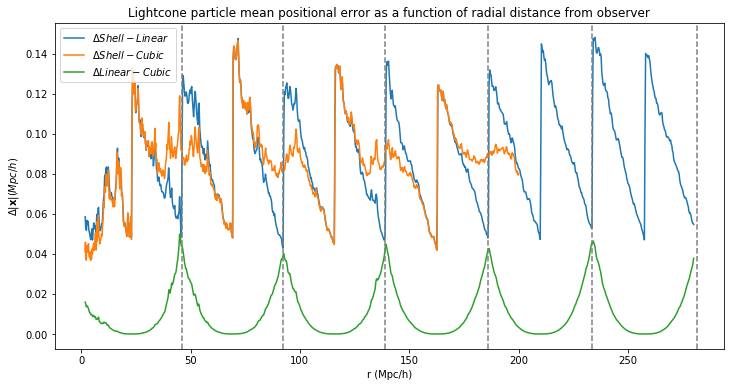

In [57]:
plt.figure(figsize = (12,6))
plt.plot(bin_edges1[1::], bin_means1, label='$\Delta Shell-Linear$')
plt.plot(bin_edges2[1::], bin_means2, label='$\Delta Shell-Cubic$')
plt.plot(bin_edges3[1::], bin_means3, label='$\Delta Linear-Cubic$')
for r in DC_z:
    plt.axvline(x=r, color = 'grey', linestyle = '--')
plt.legend()
plt.ylabel('$\Delta \| \mathbf{x} \|(Mpc/h)$')
plt.xlabel('r (Mpc/h)')
plt.title('Lightcone particle mean positional error as a function of radial distance from observer')
plt.savefig('mean_error_vs_r_inear_interp.png')
plt.show()

In [31]:
p1.size

32514911

In [32]:
r1 = np.sqrt(p1['pos']['x']**2 + p1['pos']['y']**2 + p1['pos']['z']**2 )

In [33]:
v1 = np.sqrt(p1['vel']['x']**2 + p1['vel']['y']**2 + p1['vel']['z']**2)

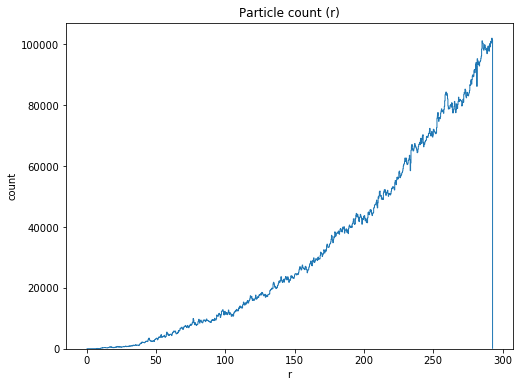

In [34]:
fig = plt.subplots(figsize = (8,6))
plt.hist(r1 , density=False, log=False, bins=1000,  histtype='step', )
plt.xlabel('r')
plt.ylabel('count')
plt.title('Particle count (r)')
#plt.legend()
#plt.savefig('error_histogram.png')
plt.show()

In [58]:
bin_means, bin_edges, binnumber = stats.binned_statistic(r1, v1, statistic='mean', bins=1000)

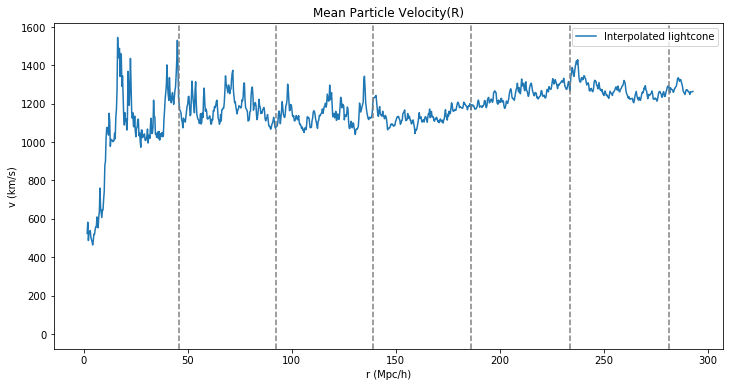

In [59]:
plt.figure(figsize = (12,6))
plt.plot(bin_edges[1::], bin_means, label = 'Interpolated lightcone')
p#lt.plot(bin_edges1[1::], bin_means1, label = 'Shelled lightcone')
for r in DC_z:
    lab = '{0:02.1f}'.format(r)
    plt.axvline(x=r, color = 'grey', linestyle = '--')
plt.legend()
plt.xlabel('r (Mpc/h)')
plt.ylabel('v (km/s)')
plt.title('Mean Particle Velocity(R)')
plt.savefig('velocity_vs_r_fix_H0.png')
plt.show()

In [181]:
DC_max =[ 3.05491548e+02,  2.57556458e+02,  2.09953608e+02,
        1.62692110e+02,  1.15780694e+02,  6.92276983e+01,  2.30410665e+01]